## CV Bias from Unsupervised Preprocessing (Rescaled Lasso Demo)

=== Demo summary (Holdout MSE) ===
N=120, p=300, df=4, sigma=10.0, reps=25
Correct   mean MSE: 1843.5308   (std 304.5607)
Incorrect mean MSE: 1859.5901   (std 323.7188)
Penalty (Incorrect - Correct): 16.0592


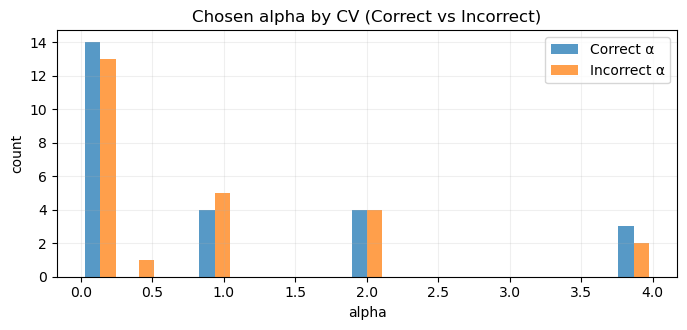

/tmp/ipykernel_3739/3090009210.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cmse, imse], labels=["Correct", "Incorrect"], showmeans=True)


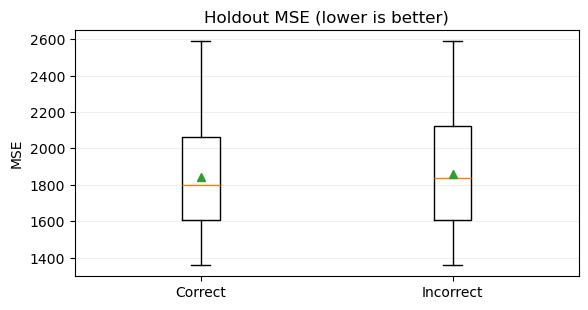

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


# -----------------------------
# 1) Preprocessing (as in the paper): scale each feature using sigma_j = sqrt(mean(x^2))
#    (we assume the feature means are ~ 0, as in the paper's setting)
# -----------------------------
class UnitVarScalerAssumingZeroMean(BaseEstimator, TransformerMixin):
    def __init__(self, eps=1e-12):
        self.eps = eps

    def fit(self, X, y=None):
        X = np.asarray(X)
        # sigma_j^2 = mean(x^2)
        sigma2 = np.mean(X * X, axis=0)
        self.sigma_ = np.sqrt(np.maximum(sigma2, self.eps))
        return self

    def transform(self, X):
        X = np.asarray(X)
        return X / self.sigma_


# -----------------------------
# 2) Data generator (similar to Section 6): X and beta from t(df), y = X beta + noise
# -----------------------------
def generate_data(rng, n, p, df=4, sigma=10.0, with_intercept=False):
    X = rng.standard_t(df, size=(n, p))
    beta = rng.standard_t(df, size=(p,))
    intercept = rng.standard_t(df) if with_intercept else 0.0
    y = X @ beta + intercept
    if sigma > 0:
        y = y + rng.normal(0.0, sigma, size=n)
    return X, y


# -----------------------------
# 3) One experiment: Correct vs Incorrect, both choose alpha using CV
# -----------------------------
def one_rep(rng, N=120, p=300, df=4, sigma=10.0, holdout_mult=50, cv_folds=10):
    # Train+Validation data
    X, y = generate_data(rng, n=N, p=p, df=df, sigma=sigma, with_intercept=False)
    # Large holdout set (for truly unbiased evaluation)
    Xh, yh = generate_data(rng, n=holdout_mult * N, p=p, df=df, sigma=sigma, with_intercept=False)

    alphas = [2**i for i in range(-10, 11)]
    base_model = Lasso(fit_intercept=False, max_iter=5000, tol=1e-3)

    # ---- Correct: preprocessing is inside the CV loop (via a Pipeline)
    correct_pipe = Pipeline([
        ("scaler", UnitVarScalerAssumingZeroMean()),
        ("model", base_model)
    ])
    correct_cv = GridSearchCV(
        correct_pipe,
        param_grid={"model__alpha": alphas},
        scoring="neg_mean_squared_error",
        cv=cv_folds,
        n_jobs=1,
        refit=True
    )
    correct_cv.fit(X, y)
    yhat = correct_cv.predict(Xh)
    correct_mse = mean_squared_error(yh, yhat)
    correct_best_alpha = correct_cv.best_params_["model__alpha"]

    # ---- Incorrect: preprocessing is fit on the full X before CV (information leakage)
    scaler = UnitVarScalerAssumingZeroMean()
    X_scaled = scaler.fit_transform(X)

    incorrect_cv = GridSearchCV(
        base_model,
        param_grid={"alpha": alphas},
        scoring="neg_mean_squared_error",
        cv=cv_folds,
        n_jobs=1,
        refit=True
    )
    incorrect_cv.fit(X_scaled, y)
    Xh_scaled = scaler.transform(Xh)
    yhat2 = incorrect_cv.predict(Xh_scaled)
    incorrect_mse = mean_squared_error(yh, yhat2)
    incorrect_best_alpha = incorrect_cv.best_params_["alpha"]

    return correct_mse, correct_best_alpha, incorrect_mse, incorrect_best_alpha


# -----------------------------
# 4) Classroom demo runner
# -----------------------------
def run_demo(seed=7331, reps=25, N=120, p=300, df=4, sigma=10.0):
    rng = np.random.default_rng(seed)

    cmse, imse = [], []
    calpha, ialpha = [], []

    for _ in range(reps):
        c_mse, c_a, i_mse, i_a = one_rep(rng, N=N, p=p, df=df, sigma=sigma)
        cmse.append(c_mse); imse.append(i_mse)
        calpha.append(c_a); ialpha.append(i_a)

    cmse = np.array(cmse); imse = np.array(imse)

    print("=== Demo summary (Holdout MSE) ===")
    print(f"N={N}, p={p}, df={df}, sigma={sigma}, reps={reps}")
    print(f"Correct   mean MSE: {cmse.mean():.4f}   (std {cmse.std():.4f})")
    print(f"Incorrect mean MSE: {imse.mean():.4f}   (std {imse.std():.4f})")
    print(f"Penalty (Incorrect - Correct): {(imse-cmse).mean():.4f}")

    # Plot: alpha distributions
    plt.figure(figsize=(8, 3.2))
    plt.hist([calpha, ialpha], bins=15, alpha=0.75, label=["Correct α", "Incorrect α"])
    plt.title("Chosen alpha by CV (Correct vs Incorrect)")
    plt.xlabel("alpha")
    plt.ylabel("count")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

    # Plot: MSE comparison
    plt.figure(figsize=(6.5, 3.2))
    plt.boxplot([cmse, imse], labels=["Correct", "Incorrect"], showmeans=True)
    plt.title("Holdout MSE (lower is better)")
    plt.ylabel("MSE")
    plt.grid(axis="y", alpha=0.2)
    plt.show()


# -----------------------------
# Run for class (lightweight)
# -----------------------------
run_demo(seed=7331, reps=25, N=120, p=300, df=4, sigma=10.0)
